#### Problem statement (what)
Evaluate feasibility of providing a generalisable learning advice for GA students

#### Success measure
Finding groups of students that can benefit from a similar learning plan 

In [1]:
%matplotlib inline

import requests
from io import StringIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#import hashlib
import numpy as np
from sklearn.cluster import KMeans

sns.set(style="white", context="talk")

url = "https://docs.google.com/spreadsheets/d/1vBAcGjTDiE_Bm2XBKc1PwqI5y9TF4ce2I65uHKoRPA0/export?format=csv&id=1vBAcGjTDiE_Bm2XBKc1PwqI5y9TF4ce2I65uHKoRPA0&gid=1817340627"
user_agent = {'User-Agent': "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.52 Safari/537.36"}
r = requests.get(url, headers=user_agent)

df = pd.read_csv(StringIO(r.text))
col_names = ['ts', 'algebra', 'programming', 'statistics', 'communication', 'business']
df.columns = col_names

In [2]:
# taking latest entries
print(str(df.shape[0]) + " entries found")
df = df[pd.to_datetime(df['ts'], infer_datetime_format=True) >= pd.to_datetime('today')]
del df['ts']
print(str(df.shape[0]) + " recent entries found")

# convering to numerical values
df['algebra'] = [len(x.split(',')) if type(x) is str else 0 for x in df['algebra']]
df['statistics'] = [len(x.split(',')) if type(x) is str else 0 for x in df['statistics']]
df['business'] = [len(x.split(',')) if type(x) is str else 0 for x in df['business']]
df

2 entries found
2 recent entries found


,algebra,programming,statistics,communication,business
0,5,4,5,3,4
1,1,2,0,2,0


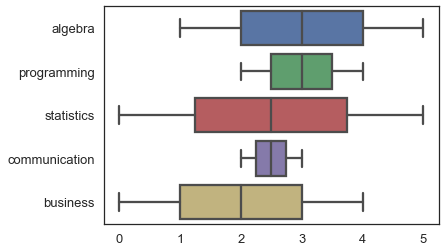

In [3]:
sns.boxplot(data=df, orient="h");

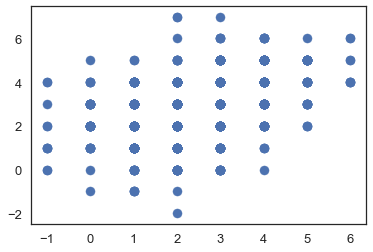

In [4]:
# from sklearn.datasets.samples_generator import make_blobs

# df, _ = make_blobs(750, n_features=5, centers=5, center_box=(1, 5))
# df = df.round()

# plt.scatter(df[:, 0], df[:, 2])
# plt.show()

Optimal k is:  4


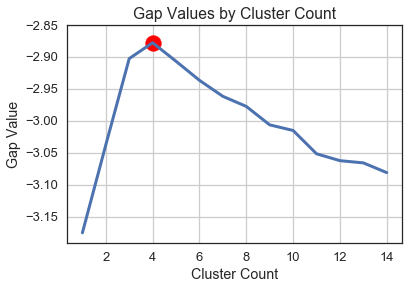

In [5]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    http://web.stanford.edu/~hastie/Papers/gap.pdf
    
    Reference:
    https://anaconda.org/milesgranger/gap-statistic/notebook
    
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
        
    # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    return (gaps.argmax() + 1, resultsdf)

k, gapdf = optimalK(df, nrefs=5, maxClusters=15)
print('Optimal k is: ', k)

# Show the results of the calculated gaps, the higher the value, the more optimal it is
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

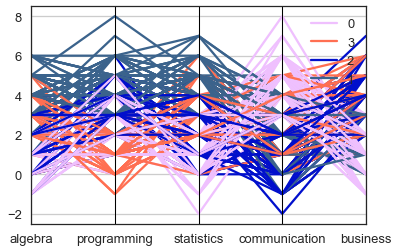

In [6]:
km = KMeans(k)
km.fit(df)

df = pd.DataFrame(df, columns=col_names[1:])
df['label'] = km.labels_
colors_list = list(colors._colors_full_map.values())
idx = np.random.randint(0, len(colors_list), len(df.label.unique()))
colors = [colors_list[i] for i in idx]
pd.plotting.parallel_coordinates(df.drop_duplicates(), 'label', color=colors);

          algebra  programming  statistics  communication    business
count  156.000000   156.000000  156.000000     156.000000  156.000000
mean     1.333333     2.596154    1.326923       4.416667    1.153846
std      1.049321     0.982287    1.072612       0.996499    0.984747
min     -1.000000     0.000000   -2.000000       2.000000   -1.000000
25%      1.000000     2.000000    1.000000       4.000000    1.000000
50%      1.000000     3.000000    1.000000       4.000000    1.000000
75%      2.000000     3.000000    2.000000       5.000000    2.000000
max      4.000000     5.000000    4.000000       8.000000    3.000000


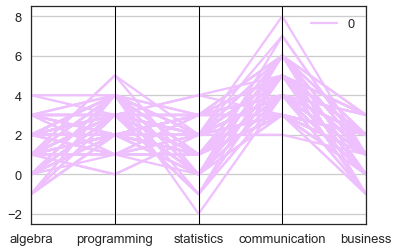



          algebra  programming  statistics  communication    business
count  207.000000   207.000000  207.000000     207.000000  207.000000
mean     2.690821     1.574879    2.908213       2.454106    3.449275
std      0.919615     0.777691    1.007872       0.993459    1.002950
min     -0.000000    -1.000000    0.000000       0.000000    1.000000
25%      2.000000     1.000000    2.000000       2.000000    3.000000
50%      3.000000     2.000000    3.000000       3.000000    3.000000
75%      3.000000     2.000000    4.000000       3.000000    4.000000
max      5.000000     3.000000    6.000000       5.000000    6.000000


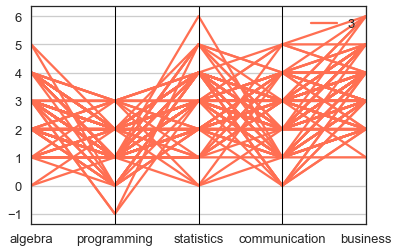



          algebra  programming  statistics  communication    business
count  218.000000   218.000000  218.000000     218.000000  218.000000
mean     1.692661     3.220183    2.619266       1.238532    3.825688
std      0.951371     1.000993    1.014637       1.010535    1.019117
min     -1.000000     1.000000    0.000000      -2.000000    2.000000
25%      1.000000     3.000000    2.000000       1.000000    3.000000
50%      2.000000     3.000000    3.000000       1.000000    4.000000
75%      2.000000     4.000000    3.000000       2.000000    5.000000
max      4.000000     6.000000    5.000000       4.000000    7.000000


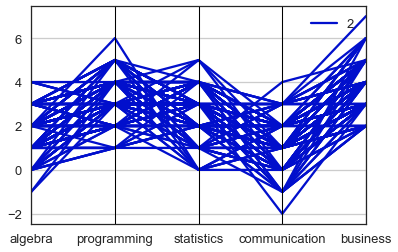



          algebra  programming  statistics  communication    business
count  169.000000   169.000000  169.000000     169.000000  169.000000
mean     3.840237     4.118343    4.390533       2.278107    2.284024
std      1.025527     1.039783    0.951893       1.046334    1.030392
min      1.000000     2.000000    2.000000      -1.000000    0.000000
25%      3.000000     3.000000    4.000000       2.000000    2.000000
50%      4.000000     4.000000    4.000000       2.000000    2.000000
75%      5.000000     5.000000    5.000000       3.000000    3.000000
max      6.000000     8.000000    7.000000       5.000000    5.000000


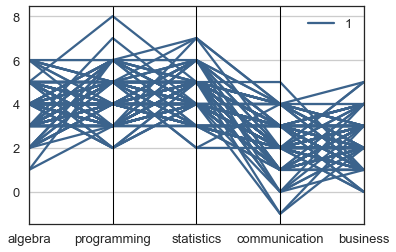

In [7]:
for i in range(len(df['label'].unique())):
    label = df['label'].unique()[i]
    print(df.loc[df['label']==label, col_names[1:]].describe())
    pd.plotting.parallel_coordinates(df.loc[df['label']==label].drop_duplicates(), 'label', color=colors[i]);
    plt.show()
    print('\n')